In [1]:
%pip install scikit-learn pandas matplotlib imbalanced-learn tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from scipy import stats

In [3]:
DATA_PATH = "letter-recognition.data"
HEADERS = [
    "lettr",
    "x-box",
    "y-box",
    "width",
    "high",
    "onpix",
    "x-bar",
    "y-bar",
    "x2bar",
    "y2bar",
    "xybar",
    "x2ybr",
    "xy2br",
    "x-ege",
    "xegvy",
    "y-ege",
    "yegvx",
]

In [4]:
data = pd.read_csv(DATA_PATH, header=None, names=HEADERS)

In [5]:
data.head()

,lettr,x-box,y-box,width,high,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


# Preprocessing

In [6]:
data.shape

(20000, 17)

<BarContainer object of 26 artists>

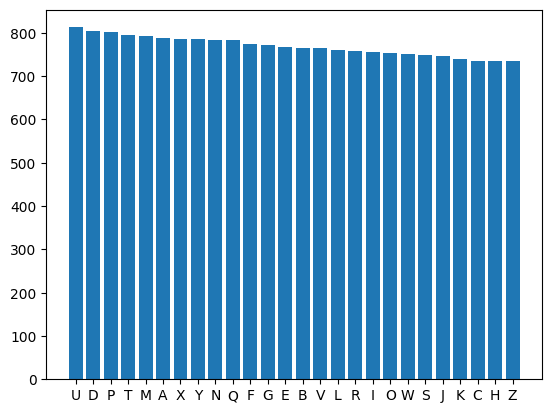

In [7]:
plt.bar(data["lettr"].value_counts().index, data["lettr"].value_counts().values)

In [8]:
# print max and min count of a letter
max_count = data["lettr"].value_counts().max()
min_count = data["lettr"].value_counts().min()
# print how many % more is the max than the min
print(max_count)
print(min_count)
print(f"Max is {(1 - max_count / min_count) * (-1) * 100} more than min")

813
734
Max is 10.762942779291551 more than min


In [9]:
# remove duplicates
data.drop_duplicates(inplace=True)

In [10]:
data.shape

(18668, 17)

<BarContainer object of 26 artists>

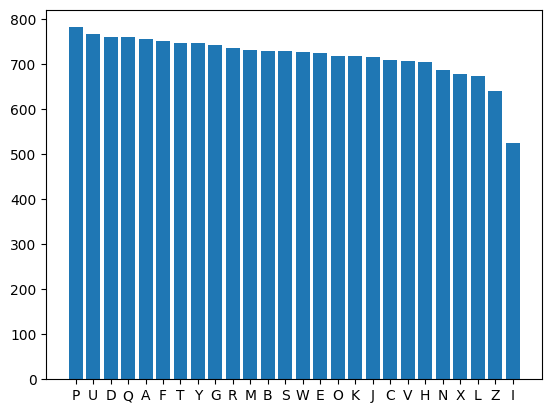

In [11]:
plt.bar(data["lettr"].value_counts().index, data["lettr"].value_counts().values)

In [12]:
# remove outliers
z_scores = stats.zscore(data[HEADERS[1:]])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
data = data[filtered_entries]

In [13]:
data.shape

(17257, 17)

<BarContainer object of 26 artists>

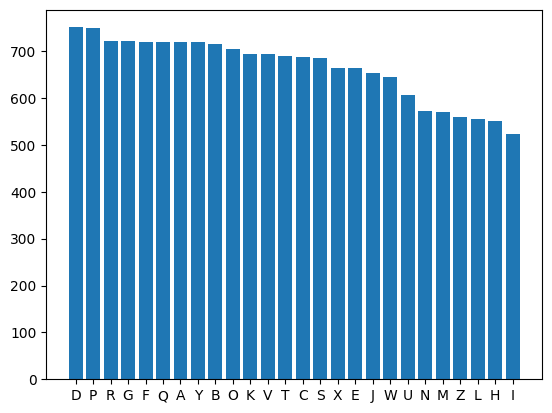

In [14]:
plt.bar(data["lettr"].value_counts().index, data["lettr"].value_counts().values)

In [15]:
# print max and min count of a letter
max_count = data["lettr"].value_counts().max()
min_count = data["lettr"].value_counts().min()
# print how many % more is the max than the min
print(max_count)
print(min_count)
print(f"Max is {(1 - max_count / min_count) * (-1) * 100} more than min")

751
523
Max is 43.594646271510506 more than min


In [16]:
# Under sampling
rus = RandomUnderSampler(random_state=42)
under_sample, under_sample_labels = rus.fit_resample(data[HEADERS[1:]], data[HEADERS[0]])

In [17]:
under_sample.shape

(13598, 16)

<BarContainer object of 26 artists>

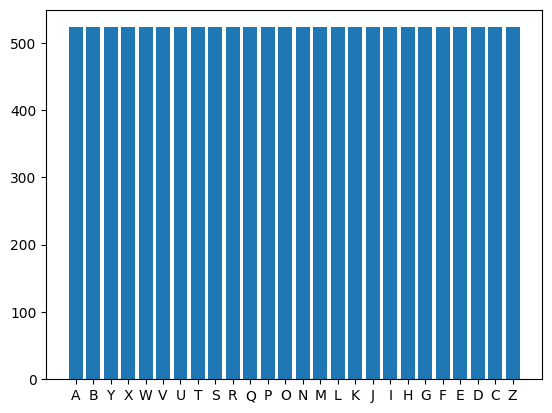

In [18]:
plt.bar(
    pd.Series(under_sample_labels).value_counts().index,
    pd.Series(under_sample_labels).value_counts().values,
)

In [19]:
# Over sampling
ros = RandomOverSampler(random_state=42)
over_sample, over_sample_labels = ros.fit_resample(data[HEADERS[1:]], data[HEADERS[0]])

In [20]:
over_sample.shape

(19526, 16)

<BarContainer object of 26 artists>

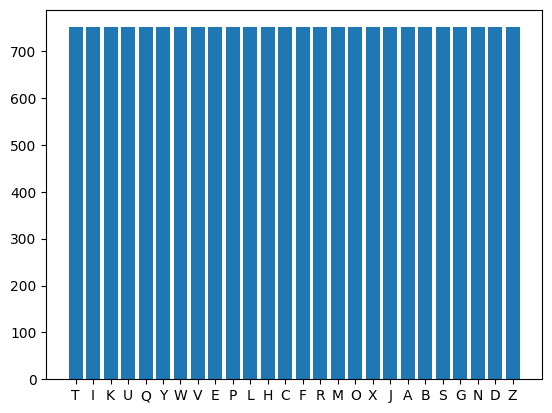

In [21]:
plt.bar(
    pd.Series(over_sample_labels).value_counts().index,
    pd.Series(over_sample_labels).value_counts().values,
)

In [22]:
data["lettr"] = data["lettr"].apply(lambda x: ord(x) - 65)
over_sample_labels = over_sample_labels.apply(lambda x: ord(x) - 65)
under_sample_labels = under_sample_labels.apply(lambda x: ord(x) - 65)

In [23]:
x_train, x_test, y_train, y_test = train_test_split(
    data[HEADERS[1:]], data[HEADERS[0]], test_size=0.20, random_state=42
)
x_train_under, x_test_under, y_train_under, y_test_under = train_test_split(
    under_sample, under_sample_labels, test_size=0.20, random_state=42
)
x_train_over, x_test_over, y_train_over, y_test_over = train_test_split(
    over_sample, over_sample_labels, test_size=0.20, random_state=42
)
print(x_train_over.shape, x_test_over.shape, y_train_over.shape, y_test_over.shape)
print(x_train_under.shape, x_test_under.shape, y_train_under.shape, y_test_under.shape)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(15620, 16) (3906, 16) (15620,) (3906,)
(10878, 16) (2720, 16) (10878,) (2720,)
(13805, 16) (3452, 16) (13805,) (3452,)


In [24]:
x_train = normalize(x_train)
x_test = normalize(x_test)
x_train_under = normalize(x_train_under)
x_test_under = normalize(x_test_under)
x_train_over = normalize(x_train_over)
x_test_over = normalize(x_test_over)

In [25]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(26, activation="softmax"),
    ]
)

model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

history = model.fit(
    x_train,
    y_train,
    epochs=40,
)



Epoch 1/40


432/432 [==============================] - 1s 1ms/step - loss: 2.2326 - accuracy: 0.3909
Epoch 2/40
432/432 [==============================] - 0s 1ms/step - loss: 1.3493 - accuracy: 0.6154
Epoch 3/40
432/432 [==============================] - 0s 840us/step - loss: 1.1550 - accuracy: 0.6730
Epoch 4/40
432/432 [==============================] - 0s 836us/step - loss: 1.0473 - accuracy: 0.7042
Epoch 5/40
432/432 [==============================] - 0s 833us/step - loss: 0.9672 - accuracy: 0.7239
Epoch 6/40
432/432 [==============================] - 0s 835us/step - loss: 0.9009 - accuracy: 0.7428
Epoch 7/40
432/432 [==============================] - 0s 839us/step - loss: 0.8507 - accuracy: 0.7570
Epoch 8/40
432/432 [==============================] - 0s 888us/step - loss: 0.7951 - accuracy: 0.7723
Epoch 9/40
432/432 [==============================] - 0s 891us/step - loss: 0.7533 - accuracy: 0.7824
Epoch 10/40
432/432 [==============================] - 0s 942us/step - loss: 0.709

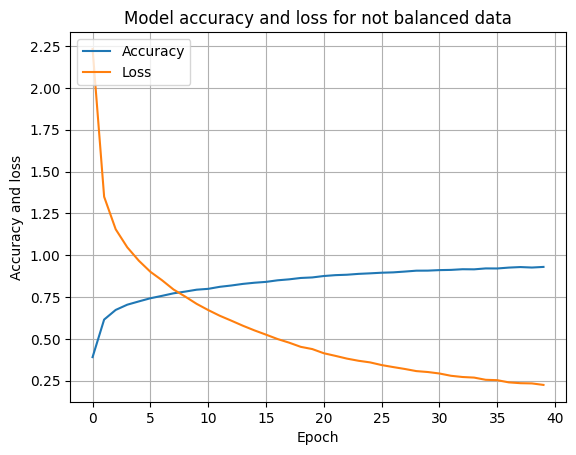

In [26]:
# draw a line graph of accuracy and loss over epochs
plt.plot(history.history["accuracy"])
plt.plot(history.history["loss"])
plt.title("Model accuracy and loss for not balanced data")
plt.ylabel("Accuracy and loss")
plt.xlabel("Epoch")
plt.grid()
plt.legend(["Accuracy", "Loss"], loc="upper left")
plt.show()

In [27]:
print(f"Accuracy: {accuracy_score(y_test, np.argmax(model.predict(x_test), axis=1))}")
print(f"F1: {f1_score(y_test, np.argmax(model.predict(x_test), axis=1), average='macro')}")

108/108 [==============================] - 0s 683us/step
Accuracy: 0.9110660486674391
108/108 [==============================] - 0s 665us/step
F1: 0.9117258130444419


In [28]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(26, activation="softmax"),
    ]
)

model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

history = model.fit(
    x_train_over,
    y_train_over,
    epochs=40,
)

Epoch 1/40
489/489 [==============================] - 1s 888us/step - loss: 2.1270 - accuracy: 0.4184
Epoch 2/40
489/489 [==============================] - 0s 850us/step - loss: 1.3019 - accuracy: 0.6305
Epoch 3/40
489/489 [==============================] - 0s 834us/step - loss: 1.1216 - accuracy: 0.6827
Epoch 4/40
489/489 [==============================] - 0s 832us/step - loss: 1.0104 - accuracy: 0.7161
Epoch 5/40
489/489 [==============================] - 0s 849us/step - loss: 0.9328 - accuracy: 0.7360
Epoch 6/40
489/489 [==============================] - 0s 895us/step - loss: 0.8557 - accuracy: 0.7600
Epoch 7/40
489/489 [==============================] - 0s 898us/step - loss: 0.7989 - accuracy: 0.7737
Epoch 8/40
489/489 [==============================] - 0s 840us/step - loss: 0.7436 - accuracy: 0.7866
Epoch 9/40
489/489 [==============================] - 0s 842us/step - loss: 0.6970 - accuracy: 0.7973
Epoch 10/40
489/489 [==============================] - 0s 843us/step - loss: 0.655

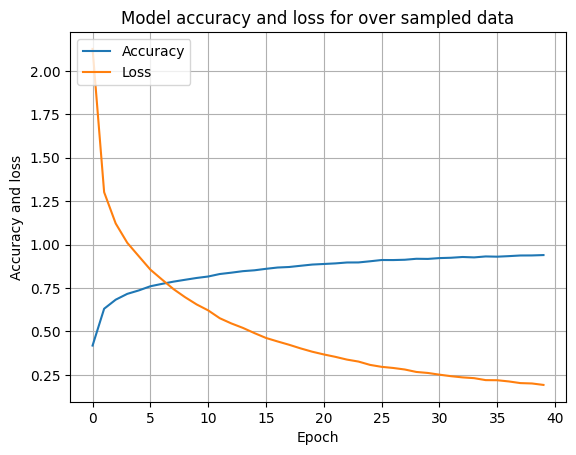

In [29]:
# draw a line graph of accuracy and loss over epochs
plt.plot(history.history["accuracy"])
plt.plot(history.history["loss"])
plt.title("Model accuracy and loss for over sampled data")
plt.ylabel("Accuracy and loss")
plt.xlabel("Epoch")
plt.grid()
plt.legend(["Accuracy", "Loss"], loc="upper left")
plt.show()

In [30]:
print(
    f"Accuracy: {accuracy_score(y_test_over, np.argmax(model.predict(x_test_over), axis=1))}"
)
print(
    f"F1: {f1_score(y_test_over, np.argmax(model.predict(x_test_over), axis=1), average='macro')}"
)

123/123 [==============================] - 0s 729us/step
Accuracy: 0.923963133640553
123/123 [==============================] - 0s 672us/step
F1: 0.9234958051979087


In [31]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(26, activation="softmax"),
    ]
)

model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

history = model.fit(
    x_train_under,
    y_train_under,
    epochs=40,
)

Epoch 1/40
340/340 [==============================] - 1s 864us/step - loss: 2.3630 - accuracy: 0.3763
Epoch 2/40
340/340 [==============================] - 0s 870us/step - loss: 1.4536 - accuracy: 0.5894
Epoch 3/40
340/340 [==============================] - 0s 851us/step - loss: 1.2463 - accuracy: 0.6481
Epoch 4/40
340/340 [==============================] - 0s 922us/step - loss: 1.1301 - accuracy: 0.6828
Epoch 5/40
340/340 [==============================] - 0s 861us/step - loss: 1.0590 - accuracy: 0.7019
Epoch 6/40
340/340 [==============================] - 0s 869us/step - loss: 0.9872 - accuracy: 0.7232
Epoch 7/40
340/340 [==============================] - 0s 881us/step - loss: 0.9371 - accuracy: 0.7375
Epoch 8/40
340/340 [==============================] - 0s 863us/step - loss: 0.8803 - accuracy: 0.7502
Epoch 9/40
340/340 [==============================] - 0s 961us/step - loss: 0.8360 - accuracy: 0.7594
Epoch 10/40
340/340 [==============================] - 0s 866us/step - loss: 0.795

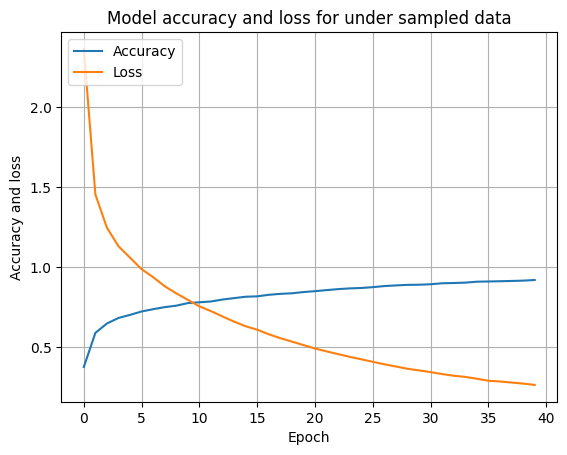

In [32]:
# draw a line graph of accuracy and loss over epochs
plt.plot(history.history["accuracy"])
plt.plot(history.history["loss"])
plt.title("Model accuracy and loss for under sampled data")
plt.ylabel("Accuracy and loss")
plt.xlabel("Epoch")
plt.grid()
plt.legend(["Accuracy", "Loss"], loc="upper left")
plt.show()

In [33]:
print(
    f"Accuracy: {accuracy_score(y_test_under, np.argmax(model.predict(x_test_under), axis=1))}"
)
print(
    f"F1: {f1_score(y_test_under, np.argmax(model.predict(x_test_under), axis=1), average='macro')}"
)

85/85 [==============================] - 0s 702us/step
Accuracy: 0.9014705882352941
85/85 [==============================] - 0s 670us/step
F1: 0.9006220439755618


In [34]:
knn = KNeighborsClassifier(n_neighbors=3, n_jobs=-1, metric="euclidean")
knn.fit(x_train, y_train)

KNeighborsClassifier(metric='euclidean', n_jobs=-1, n_neighbors=3)

In [35]:
y_pred = knn.predict(x_test)
print("Accuracy score: ", accuracy_score(y_test, y_pred))
print("F1 score: ", f1_score(y_test, y_pred, average="macro"))

Accuracy score:  0.944090382387022
F1 score:  0.9443210856254098


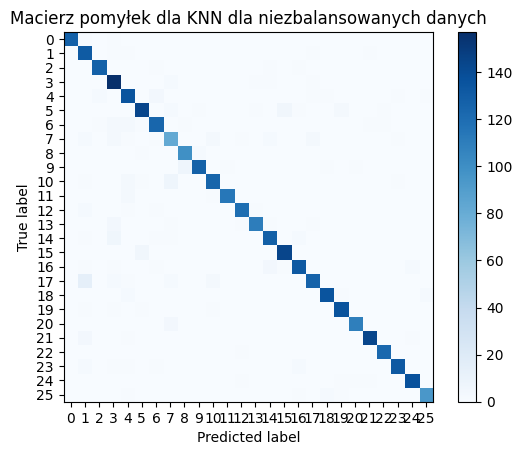

In [36]:
matrix = confusion_matrix(y_test, y_pred)
plt.imshow(matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Macierz pomyłek dla KNN dla niezbalansowanych danych")
plt.colorbar()
tick_marks = np.arange(26)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

In [37]:
knn.fit(x_train_under, y_train_under)

KNeighborsClassifier(metric='euclidean', n_jobs=-1, n_neighbors=3)

In [38]:
y_pred = knn.predict(x_test_under)
print("Accuracy score: ", accuracy_score(y_test_under, y_pred))
print("F1 score: ", f1_score(y_test_under, y_pred, average="macro"))

Accuracy score:  0.9338235294117647
F1 score:  0.9338804730994741


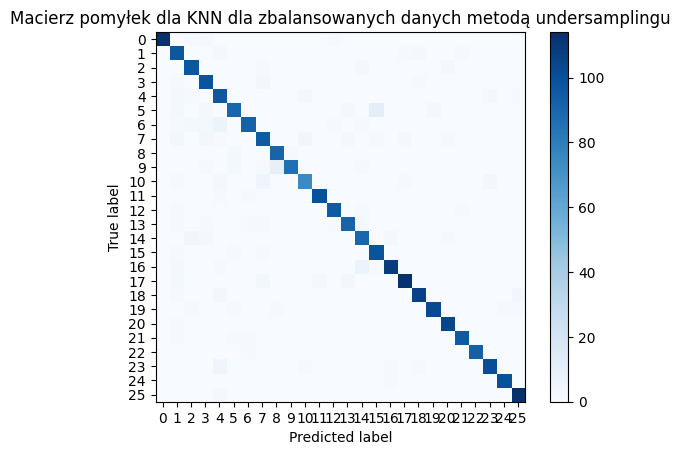

In [39]:
matrix = confusion_matrix(y_test_under, y_pred)
plt.imshow(matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Macierz pomyłek dla KNN dla zbalansowanych danych metodą undersamplingu")
plt.colorbar()
tick_marks = np.arange(26)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

In [40]:
knn.fit(x_train_over, y_train_over)

KNeighborsClassifier(metric='euclidean', n_jobs=-1, n_neighbors=3)

In [41]:
y_pred = knn.predict(x_test_over)
print("Accuracy score: ", accuracy_score(y_test_over, y_pred))
print("F1 score: ", f1_score(y_test_over, y_pred, average="macro"))

Accuracy score:  0.9528929851510497
F1 score:  0.9520785571164331


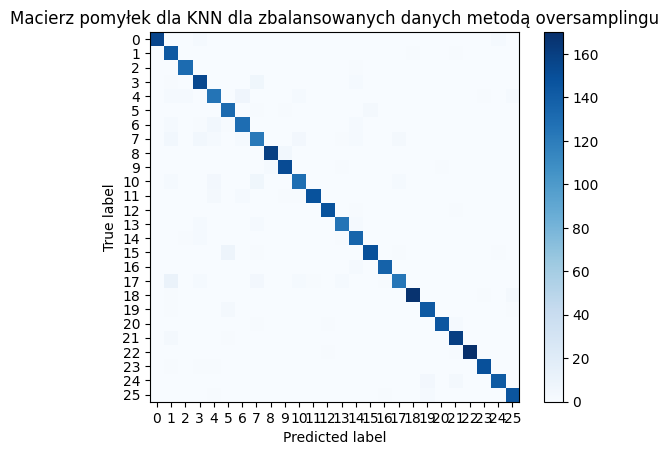

In [42]:
matrix = confusion_matrix(y_test_over, y_pred)
plt.imshow(matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Macierz pomyłek dla KNN dla zbalansowanych danych metodą oversamplingu")
plt.colorbar()
tick_marks = np.arange(26)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

In [43]:
param_grid = {"n_neighbors": [3, 5, 7, 9, 11, 13, 15]}
grid = GridSearchCV(knn, param_grid, n_jobs=-1)
grid.fit(x_train, y_train)
grid.best_params_

{'n_neighbors': 3}

In [44]:
grid.fit(x_train_under, y_train_under)
grid.best_params_

{'n_neighbors': 3}

In [45]:
grid.fit(x_train_over, y_train_over)
grid.best_params_

{'n_neighbors': 3}